<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Advance_Regression/01_Generalized_Linear_Models/02-01-07-03-glm-non-normal-beta-python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 7.3 Beta Regression

Beta regression is a statistical modeling technique for continuous response variables within the interval $(0, 1)$. This makes it particularly suitable for data such as proportions, rates, and probabilities, like conversion rates in marketing campaigns or percentage allocations. In this tutorial, we will demonstrate the entire process using synthetic data. We'll cover data generation, model fitting, and performance metrics, including pseudo $R^2$ and model coefficients, all without relying on any built-in Python packages beyond core scientific libraries. Following this, we will simplify the modeling of beta regression by utilizing the `BetaModel` class from the `statsmodels` package and demonstrate how to interpret the results practically. Additionally, we will explore the marginal effects and assess the model's performance through cross-validation. This hands-on introduction will equip you with the necessary skills to apply beta regression to real-world datasets with bounded response variables.

# Overview

Beta regression is a type of regression model used when the dependent variable $y$ is continuous and constrained within an interval, typically $(0, 1)$. This is common for proportions or rates, like percentages (excluding 0 and 1). Traditional linear regression models don’t work well in these cases, as they can predict values outside the $(0, 1)$ interval, and assumptions of normality and homoscedasticity may not hold. Beta regression is built on the beta distribution, which is well-suited for modeling such bounded data.

Here’s a step-by-step explanation of beta regression, including key mathematical details.

***Understanding the Beta Distribution***

The beta distribution is a continuous probability distribution defined on the interval $(0, 1)$. Its probability density function is given by:

$$ f(y; \alpha, \beta) = \frac{y^{\alpha - 1} (1 - y)^{\beta - 1}}{B(\alpha, \beta)} $$

where:

- $ y \in (0, 1) $ is the variable of interest.
- $\alpha > 0$ and $\beta > 0$ are shape parameters.
- $B(\alpha, \beta)$ is the beta function, which normalizes the distribution:

$$ B(\alpha, \beta) = \int_0^1 t^{\alpha - 1} (1 - t)^{\beta - 1} \, dt $$

The mean $\mu$ and variance $\sigma^2$ of a beta distribution are given by:

$$ \mu = \frac{\alpha}{\alpha + \beta}, \quad \sigma^2 = \frac{\alpha \beta}{(\alpha + \beta)^2 (\alpha + \beta + 1)} $$

The mean $\mu$ represents the central tendency, while the variance $\sigma^2$ reflects the spread.

***Modeling the Mean with a Link Function***

In beta regression, we model the mean $\mu$ of the beta distribution as a function of the predictors $X$. Since $\mu \in (0, 1)$, we apply a link function $g(\cdot)$ to transform $\mu$ into an unbounded linear predictor:

$$ g(\mu) = X \beta $$

Common choices for the link function $g(\cdot)$ are:

- The logit link: $g(\mu) = \log \left( \frac{\mu}{1 - \mu} \right)$
- The probit link: $g(\mu) = \Phi^{-1}(\mu)$, where $\Phi^{-1}$ is the inverse CDF of the normal distribution

The link function ensures that $\mu$ lies between 0 and 1, regardless of the values of $X$.

***Specifying the Dispersion Parameter***

In addition to the mean, beta regression also incorporates a precision (or dispersion) parameter, often denoted by $\phi$. The parameters $\alpha$ and $\beta$ can be reparametrized in terms of $\mu$ and $\phi$ as follows:

$$ \alpha = \mu \phi, \quad \beta = (1 - \mu) \phi $$

Here, $\phi$ is related to the variance of $y$, with larger values of $\phi$ leading to a smaller variance. Unlike in ordinary regression, where variance is typically constant, in beta regression, the dispersion parameter $\phi$ allows for flexibility in the variability of $y$ based on the values of the predictors.

***Defining the Likelihood Function***

The likelihood function for beta regression is based on the beta distribution’s PDF. Given $n$ observations, the likelihood function is:

$$ L(\beta, \phi; y) = \prod_{i=1}^n f(y_i; \mu_i, \phi) = \prod_{i=1}^n \frac{y_i^{\mu_i \phi - 1} (1 - y_i)^{(1 - \mu_i) \phi - 1}}{B(\mu_i \phi, (1 - \mu_i) \phi)} $$

Taking the logarithm of the likelihood function (for simplicity in optimization) gives the log-likelihood:

$$ \log L(\beta, \phi; y) = \sum_{i=1}^n \left[ (\mu_i \phi - 1) \log y_i + ((1 - \mu_i) \phi - 1) \log (1 - y_i) - \log B(\mu_i \phi, (1 - \mu_i) \phi) \right] $$

***Estimating Parameters Using Maximum Likelihood***

To estimate the parameters $\beta$ and $\phi$, we maximize the log-likelihood function. This is often done using numerical optimization techniques because the log-likelihood function is complex and does not have a closed-form solution.

The parameter estimates $\hat{\beta}$ and $\hat{\phi}$ are obtained by solving:

$$ \frac{\partial \log L}{\partial \beta} = 0 \quad \text{and} \quad \frac{\partial \log L}{\partial \phi} = 0 $$

Once these parameters are estimated, they can be used to predict the mean response $\mu$ for new data points.

***Interpreting the Model***

After fitting a beta regression model, we interpret $\beta$ coefficients in terms of their effect on the log-odds (if using the logit link) of the mean $\mu$. A positive $\beta_j$ implies that an increase in $X_j$ is associated with an increase in the mean of $y$, while a negative $\beta_j$ implies the opposite.

The dispersion parameter $\phi$ provides insight into the variability of $y$: a high $\phi$ implies that the values of $y$ are tightly clustered around the mean, while a low $\phi$ suggests more variability.

## Beta Regression Model from Scratch

To demonstrate beta regression in Python without using any specialized package, we'll need to work directly with the beta distribution and likelihood functions. This example will walk through generating synthetic data, defining the likelihood function for beta regression, estimating parameters with numerical optimization, and evaluating model performance.

### Generate Synthetic Data

We'll generate synthetic data with four predictors and a target variable $y$ constrained between $(0, 1)$. We'll simulate the beta-distributed response $y$ based on a linear combination of the predictors transformed through a logistic function to ensure values stay in the $(0, 1)$ range.

In [5]:
import numpy as np
import pandas as pd
from scipy.stats import beta as beta_dist  # Explicitly import and rename to avoid conflict
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns

# Set seed for reproducibility
np.random.seed(123)

# Generate predictors
n = 100
X1 = np.random.normal(0, 1, n)
X2 = np.random.normal(0, 1, n)
X3 = np.random.normal(0, 1, n)
X4 = np.random.normal(0, 1, n)

# Define true coefficients
beta_true = np.array([0.5, -0.3, 0.8, -0.2, 0.1])  # Intercept + 4 predictors
phi = 10  # Dispersion parameter

# Calculate the linear predictor and apply logistic link function to get mu
linear_predictor = (beta_true[0] + beta_true[1]*X1 + beta_true[2]*X2 +
                    beta_true[3]*X3 + beta_true[4]*X4)
mu = 1 / (1 + np.exp(-linear_predictor))

# Generate beta-distributed response variable y
alpha = mu * phi
beta_param = (1 - mu) * phi
y = beta_dist.rvs(alpha, beta_param, size=n)

# Combine data into a DataFrame
data = pd.DataFrame({'y': y, 'X1': X1, 'X2': X2, 'X3': X3, 'X4': X4})
print(data.head())

          y        X1        X2        X3        X4
0  0.911221 -1.085631  0.642055  0.703310  0.765055
1  0.139528  0.997345 -1.977888 -0.598105 -0.828989
2  0.526427  0.282978  0.712265  2.200702 -0.659151
3  0.959179 -1.506295  2.598304  0.688297  0.611124
4  0.767396 -0.578600 -0.024626 -0.006307 -0.144013


### Define the Beta Regression Log-Likelihood Function

We'll create a function to compute the log-likelihood of the beta regression model. The function takes the model parameters (coefficients $\beta$ and dispersion parameter $\phi$) and the data as input and returns the negative log-likelihood. We use `beta.logpdf` from `scipy.stats` to calculate the log-likelihood for each observation.

In [7]:
# Define the Beta Regression Log-Likelihood Function
def log_likelihood(params, data):
    # Extract parameters
    beta_coeffs = params[:5]  # Renamed to avoid conflict with beta distribution
    phi = np.exp(params[5])  # dispersion parameter, transformed to be positive
    
    # Linear predictor
    X = np.column_stack([np.ones(len(data)), data.iloc[:, 1:].values])  # Add intercept to predictors matrix
    linear_predictor = X @ beta_coeffs
    mu = 1 / (1 + np.exp(-linear_predictor))  # Logistic link function
    
    # Calculate alpha and beta parameters of the beta distribution
    alpha = mu * phi
    beta_param = (1 - mu) * phi
    
    # Log-likelihood calculation using beta_dist
    ll = np.sum(beta_dist.logpdf(data['y'], alpha, beta_param))
    return -ll  # Return negative log-likelihood for minimization

### Fit the Model Using Numerical Optimization

We’ll use `minimize` from `scipy.optimize` to minimize the negative log-likelihood and estimate the parameters. We start with random initial guesses for the parameters and use the BFGS optimization method. The `hess_inv` from the result allows us to approximate standard errors later.

In [8]:
# Optimize
fit = minimize(log_likelihood, initial_params, args=(data,), method='BFGS')

# Extract estimated parameters
beta_hat = fit.x[:5]
phi_hat = np.exp(fit.x[5])

print("Estimated coefficients (beta):")
print(beta_hat)
print("Estimated dispersion parameter (phi):")
print(phi_hat)

Estimated coefficients (beta):
[ 0.4271417  -0.29587964  0.74758691 -0.22467689  0.14719595]
Estimated dispersion parameter (phi):
11.951286549020018


### Display Model Summary

Let's create a summary table for the estimated coefficients and their standard errors. The inverse Hessian from `minimize` can be used to approximate standard errors.

In [9]:
# Standard errors from the inverse Hessian
se = np.sqrt(np.diag(fit.hess_inv))

# Extract estimated coefficients
beta_est = fit.x[:5]

# Print results
summary_table = pd.DataFrame({
    'Coefficient': ['Intercept', 'X1', 'X2', 'X3', 'X4'],
    'Estimate': beta_est,
    'Std. Error': se[:5]
})
print(summary_table)

  Coefficient  Estimate  Std. Error
0   Intercept  0.427142    0.066909
1          X1 -0.295880    0.056696
2          X2  0.747587    0.073020
3          X3 -0.224677    0.064709
4          X4  0.147196    0.070386


### Dispersion Parameter

In [10]:
# Dispersion parameter has already been calculated as phi_hat
print("Dispersion Parameter (phi) from the model:", phi_hat)

Dispersion Parameter (phi) from the model: 11.951286549020018


### Evaluate Model Performance

We’ll use the estimated parameters to compute the fitted values of $\mu$ and check the model’s performance by comparing predicted values to actual values.

In [11]:
# Compute predicted values of mu
X = np.column_stack([np.ones(len(data)), data.iloc[:, 1:].values])
linear_predictor_hat = X @ beta_hat
mu_hat = 1 / (1 + np.exp(-linear_predictor_hat))

# Mean Squared Error (MSE) as a performance metric
mse = np.mean((data['y'] - mu_hat)**2)
print("Mean Squared Error (MSE):")
print(mse)

Mean Squared Error (MSE):
0.016479157430070078


### Cross-validation

To evaluate the beta regression model using cross-validation, we can use a simple $k$-fold cross-validation approach. Cross-validation will split the data into k subsets, train the model on $k-1$ folds, and evaluate it on the remaining fold. We repeat this process $k$ times, each time using a different fold for validation.

Here's how to implement $k$-fold cross-validation for the beta regression model created earlier. We’ll compute the Mean Squared Error (MSE) for each fold as a performance metric and calculate the average MSE across all folds.

In [12]:
def cross_validate_beta_regression(data, k=5):
    n = len(data)
    indices = np.random.permutation(n)
    fold_size = n // k
    
    mse_values = np.zeros(k)
    
    for i in range(k):
        # Define training and validation indices
        val_start = i * fold_size
        val_end = (i + 1) * fold_size if i < k - 1 else n
        val_indices = indices[val_start:val_end]
        train_indices = np.concatenate([indices[:val_start], indices[val_end:]])
        
        train_data = data.iloc[train_indices]
        val_data = data.iloc[val_indices]
        
        # Fit the model on training data
        initial_params = np.array([0, 0, 0, 0, 0, np.log(1)])
        fit_fold = minimize(log_likelihood, initial_params, args=(train_data,), method='BFGS')
        
        # Extract the estimated parameters
        beta_hat_fold = fit_fold.x[:5]
        
        # Compute predictions for validation data
        X_val = np.column_stack([np.ones(len(val_data)), val_data.iloc[:, 1:].values])
        linear_predictor_val = X_val @ beta_hat_fold
        mu_val = 1 / (1 + np.exp(-linear_predictor_val))
        
        # Calculate MSE for this fold
        mse_values[i] = np.mean((val_data['y'] - mu_val)**2)
    
    # Return average MSE across all folds
    avg_mse = np.mean(mse_values)
    return avg_mse

# Run Cross-Validation
np.random.seed(123)
k = 5
avg_mse_cv = cross_validate_beta_regression(data, k)
print("Average Cross-Validated MSE:", avg_mse_cv)

Average Cross-Validated MSE: 0.01959712406927522


## Beta Regression in Python

In beta regression, we model the mean of the response variable (proportion) through a link function (usually a logit or log-log link) to keep predictions within the 0-1 range. The mean prediction of the response variable is often interpreted as the central tendency of the outcome for given levels of the predictors.

### Install Required Python Packages

The following Python packages are required to run this notebook. If any of these packages are not installed, you can install them using the code below:

In [ ]:
packages = [
    'numpy', 'pandas', 'scipy', 'statsmodels', 'matplotlib', 'seaborn',
    'scikit-learn'  # For cross-validation utilities if needed
]

# Note: Install missing packages via pip
# !pip install numpy pandas scipy statsmodels matplotlib seaborn scikit-learn

### Load Python Packages

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.othermod.betareg import BetaModel
from statsmodels.tools.tools import add_constant
from statsmodels.genmod.families.links import LogLog, Log
import warnings
warnings.filterwarnings('ignore')

print("Successfully loaded packages.")

Successfully loaded packages.


### Data

In this tutorial, we will use Prater's well-known gasoline yield data from 1956. The primary variable of interest is `yield`, which represents the proportion of crude oil converted to gasoline after distillation and fractionation. A beta regression model is particularly suitable for analyzing this variable. We also have two explanatory variables: `temp`, the temperature (measured in degrees Fahrenheit) at which all the gasoline has vaporized, and `batch`, a categorical variable denoting ten unique batches of conditions involved in the experiments based on various other factors.

Source: Prater NH (1956). “Estimate Gasoline Yields from Crudes.” Petroleum Refiner, 35(5), 236–238.

In [20]:
import pandas as pd

# Load the GasolineYield dataset from Rdatasets CSV
url = 'https://vincentarelbundock.github.io/Rdatasets/csv/betareg/GasolineYield.csv'
GasolineYield = pd.read_csv(url)

# Inspect column names
print("Column names in the dataset:")
print(GasolineYield.columns)

# Drop 'Unnamed: 0' only if it exists
if 'Unnamed: 0' in GasolineYield.columns:
    GasolineYield = GasolineYield.drop('Unnamed: 0', axis=1)  # Drop index column
    print("Dropped 'Unnamed: 0' column.")
else:
    print("No 'Unnamed: 0' column found, proceeding without dropping.")

# Verify the dataset
print("\nFirst few rows of the dataset:")
print(GasolineYield.head())
print("\nDataset info:")
print(GasolineYield.info())



Column names in the dataset:
Index(['rownames', 'yield', 'gravity', 'pressure', 'temp10', 'temp', 'batch'], dtype='object')
No 'Unnamed: 0' column found, proceeding without dropping.

First few rows of the dataset:
   rownames  yield  gravity  pressure  temp10  temp  batch
0         1  0.122     50.8       8.6     190   205      1
1         2  0.223     50.8       8.6     190   275      1
2         3  0.347     50.8       8.6     190   345      1
3         4  0.457     50.8       8.6     190   407      1
4         5  0.080     40.8       3.5     210   218      2

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   rownames  32 non-null     int64  
 1   yield     32 non-null     float64
 2   gravity   32 non-null     float64
 3   pressure  32 non-null     float64
 4   temp10    32 non-null     int64  
 5   temp      32 non-null     int64  
 6

First, we use `describe()` function of pandas to do general diagnosis of all variables.

In [21]:
# General diagnosis of all variables
print("\nDataset description:")
print(GasolineYield.describe())


Dataset description:
        rownames      yield    gravity  pressure      temp10        temp  \
count  32.000000  32.000000  32.000000  32.00000   32.000000   32.000000   
mean   16.500000   0.196594  39.250000   4.18125  241.500000  332.093750   
std     9.380832   0.107224   5.635429   2.61983   37.541375   69.755961   
min     1.000000   0.028000  31.800000   0.20000  190.000000  205.000000   
25%     8.750000   0.116500  36.625000   1.80000  217.000000  274.500000   
50%    16.500000   0.178000  40.000000   4.80000  231.000000  349.000000   
75%    24.250000   0.270500  40.925000   6.10000  268.750000  383.000000   
max    32.000000   0.457000  50.800000   8.60000  316.000000  444.000000   

           batch  
count  32.000000  
mean    5.250000  
std     2.884888  
min     1.000000  
25%     3.000000  
50%     5.000000  
75%     7.250000  
max    10.000000  


In [30]:
# Ensure batch is categorical
GasolineYield['batch'] = pd.Categorical(GasolineYield['batch'])

# Prepare exog_mean: keep temp as continuous, encode batch as dummy variables
exog_mean = add_constant(GasolineYield[['temp']])  # temp is continuous, add intercept
exog_mean = pd.concat([exog_mean, pd.get_dummies(GasolineYield['batch'], prefix='batch', drop_first=True)], axis=1)
exog_mean = exog_mean.astype(np.float64)

# Verify exog_mean
print("exog_mean dtypes:")
print(exog_mean.dtypes)
print("\nFirst few rows of exog_mean:")
print(exog_mean.head())

# Prepare exog_mean: keep temp as continuous, encode batch as dummy variables
exog_mean = add_constant(GasolineYield[['temp']])  # temp is continuous, add intercept
exog_mean = pd.concat([exog_mean, pd.get_dummies(GasolineYield['batch'], prefix='batch', drop_first=True)], axis=1)
exog_mean = exog_mean.astype(np.float64)

# Verify exog_precision
# Verify exog_mean
print("exog_mean dtypes:")
print(exog_mean.dtypes)
print("\nFirst few rows of exog_mean:")
print(exog_mean.head())

# Verify endog is numeric
print("\nendog dtype:")
print(GasolineYield['yield'].dtype)

exog_mean dtypes:
const       float64
temp        float64
batch_2     float64
batch_3     float64
batch_4     float64
batch_5     float64
batch_6     float64
batch_7     float64
batch_8     float64
batch_9     float64
batch_10    float64
dtype: object

First few rows of exog_mean:
   const   temp  batch_2  batch_3  batch_4  batch_5  batch_6  batch_7  \
0    1.0  205.0      0.0      0.0      0.0      0.0      0.0      0.0   
1    1.0  275.0      0.0      0.0      0.0      0.0      0.0      0.0   
2    1.0  345.0      0.0      0.0      0.0      0.0      0.0      0.0   
3    1.0  407.0      0.0      0.0      0.0      0.0      0.0      0.0   
4    1.0  218.0      1.0      0.0      0.0      0.0      0.0      0.0   

   batch_8  batch_9  batch_10  
0      0.0      0.0       0.0  
1      0.0      0.0       0.0  
2      0.0      0.0       0.0  
3      0.0      0.0       0.0  
4      0.0      0.0       0.0  
exog_mean dtypes:
const       float64
temp        float64
batch_2     float64
batch_3  

## Fit Beta Models in Python

In beta regression, we model the mean of the response variable (proportion) through a link function (usually a logit or log-log link) to keep predictions within the 0-1 range. The mean prediction of the response variable is often interpreted as the central tendency of the outcome for given levels of the predictors.

The `BetaModel` class fits beta regression models for rates and proportions via maximum likelihood using a parametrization with mean (depending through a link function on the covariates) and precision parameter (called phi).

### Standard Beta Regression Model

First, we will fit a `BetaModel` where yield depends on batch and temp, using the standard `logit` link function:

In [31]:
# Fit standard Beta Regression Model (logit link)
model = BetaModel(GasolineYield['yield'], exog_mean)
fit_beta_01 = model.fit()
print(fit_beta_01.summary())

                              BetaModel Results                               
Dep. Variable:                  yield   Log-Likelihood:                 84.798
Model:                      BetaModel   AIC:                            -145.6
Method:            Maximum Likelihood   BIC:                            -128.0
Date:                Tue, 16 Sep 2025                                         
Time:                        21:46:54                                         
No. Observations:                  32                                         
Df Residuals:                      20                                         
Df Model:                          10                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.4318      0.149    -29.714      0.000      -4.724      -4.140
temp           0.0110      0.000     26.900      0.0

- Batch and temperature are both significant predictors of yield in the GasolineYield data.
- Higher values of `batch` and `temp` are associated with an increase in the mean gasoline yield, meaning these factors positively influence yield when considered individually.

The high value of the `dispersion parameter ($\phi$)` suggests that gasoline yields in the data are relatively consistent around their predicted means for the given conditions, which may indicate a good fit (less dispersion).

### Variable Dispersion Beta Regression Model

In standard beta regression, the dispersion parameter $\phi$ controls the variability of the response variable around its mean. A single (constant) $\phi$ is estimated for the entire model, implying that all observations have the same degree of variability around the mean.

In a variable dispersion model, we allow the dispersion parameter $\phi$ to vary based on one or more predictor variables. This means that $\phi$ itself is modeled as a function of some variables, just like the mean. Variable dispersion models are useful when:

- The variability of the response is expected to differ across certain levels of predictors. For example, in a clinical trial, patients from different treatment groups may exhibit varying response variability.
- The residuals from a standard beta regression model show patterns that suggest unequal dispersion across values of certain predictors.

In [33]:
# Variable Dispersion: phi depends on temp
exog_precision = add_constant(GasolineYield[['temp']])  # temp is continuous, add intercept
exog_precision = exog_precision.astype(np.float64)  # Ensure numeric

# Fit Variable Dispersion Beta Regression Model with starting parameters
# Initialize start_params: [mean params (exog_mean), precision params (exog_precision)]
num_mean_params = exog_mean.shape[1]
num_precision_params = exog_precision.shape[1]
start_params = np.zeros(num_mean_params + num_precision_params)
start_params[num_mean_params:] = np.log(10)  # Initial guess for precision parameters (log scale)

model_var = BetaModel(GasolineYield['yield'], exog_mean, exog_precision=exog_precision)
fit_beta_02 = model_var.fit(start_params=start_params, method='bfgs', maxiter=1000)
print(fit_beta_02.summary())

                              BetaModel Results                               
Dep. Variable:                  yield   Log-Likelihood:                    nan
Model:                      BetaModel   AIC:                               nan
Method:            Maximum Likelihood   BIC:                               nan
Date:                Tue, 16 Sep 2025                                         
Time:                        21:47:44                                         
No. Observations:                  32                                         
Df Residuals:                      19                                         
Df Model:                          11                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const                    0        nan        nan        nan         nan         nan
temp                     0        nan

### The Beta Regression with `log-log` link function

In binomial Generalized Linear Models (GLMs), choosing the right link function is crucial for enhancing model fit, particularly when the data includes extreme proportions (values close to 0 or 1). In such cases, we will use `loglog` link function instead of the default `logit` link.

In [34]:
# Beta Regression Model with loglog link function
model_loglog = BetaModel(GasolineYield['yield'], exog_mean, link_mean='loglog')
fit_beta_03 = model_loglog.fit()
print(fit_beta_03.summary())

                              BetaModel Results                               
Dep. Variable:                  yield   Log-Likelihood:                 84.798
Model:                      BetaModel   AIC:                            -145.6
Method:            Maximum Likelihood   BIC:                            -128.0
Date:                Tue, 16 Sep 2025                                         
Time:                        21:47:52                                         
No. Observations:                  32                                         
Df Residuals:                      20                                         
Df Model:                          10                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.4318      0.149    -29.714      0.000      -4.724      -4.140
temp           0.0110      0.000     26.900      0.0

Variable dispersion shows a significant improvement with the inclusion of the `temp` regressor.

### The Beta Regression with `link.phi = "log"` link function

Typically, a log-link leads to somewhat improved quadratic approximations of the likelihood and less iterations in the optimization. For example, refitting the loglog model with `g_phi(·) = log(·)`:

In [39]:
# Prepare exog_precision: keep temp as continuous
exog_precision = add_constant(GasolineYield[['temp']]).astype(np.float64)  # temp for phi

# Initialize start_params: [mean params (exog_mean), precision params (exog_precision)]
num_mean_params = exog_mean.shape[1]
num_precision_params = exog_precision.shape[1]
start_params = np.zeros(num_mean_params + num_precision_params)
start_params[num_mean_params:] = np.log(10)  # Initial guess for precision parameters (log scale)

# Beta Regression Model with loglog for mean and log for phi
model_loglog_logphi = BetaModel(
    GasolineYield['yield'],
    exog_mean,
    exog_precision=exog_precision,
    link_mean=LogLog(),  # Use LogLog link function object
    link_precision=Log()  # Use Log link function object
)
fit_beta_04 = model_loglog_logphi.fit(start_params=start_params, method='bfgs', maxiter=1000)
print(fit_beta_04.summary())

                              BetaModel Results                               
Dep. Variable:                  yield   Log-Likelihood:                    nan
Model:                      BetaModel   AIC:                               nan
Method:            Maximum Likelihood   BIC:                               nan
Date:                Tue, 16 Sep 2025                                         
Time:                        21:50:29                                         
No. Observations:                  32                                         
Df Residuals:                      19                                         
Df Model:                          11                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const                    0        nan        nan        nan         nan         nan
temp                     0        nan

### Model Comparison

We will compute likelihood ratio tests manually for comparisons of models.

In [40]:
from scipy.stats import chi2

# Likelihood ratio test: H0: fit_beta_01 vs HA: fit_beta_02
lr_stat_01_02 = -2 * (fit_beta_01.llf - fit_beta_02.llf)
p_value_01_02 = 1 - chi2.cdf(lr_stat_01_02, df=1)  # 1 df for added term
print(f"LR test (01 vs 02): Stat={lr_stat_01_02:.2f}, p={p_value_01_02:.4f}")

# AIC comparison
print("AIC:")
aic_df = pd.DataFrame({
    'Model': ['fit_beta_01', 'fit_beta_02', 'fit_beta_03'],
    'AIC': [fit_beta_01.aic, fit_beta_02.aic, fit_beta_03.aic]
})
print(aic_df)

LR test (01 vs 02): Stat=nan, p=nan
AIC:
         Model         AIC
0  fit_beta_01 -145.595116
1  fit_beta_02         NaN
2  fit_beta_03 -145.595116


The `temp` included as a regressor in the precision equation would no longer yield significant improvements. Thus, improvement of the model fit in the mean equation by adoption of the log-log link have waived the need for a variable precision equation.

The improvement of the model fit can also be brought out graphically in a display of predicted vs. observed values.

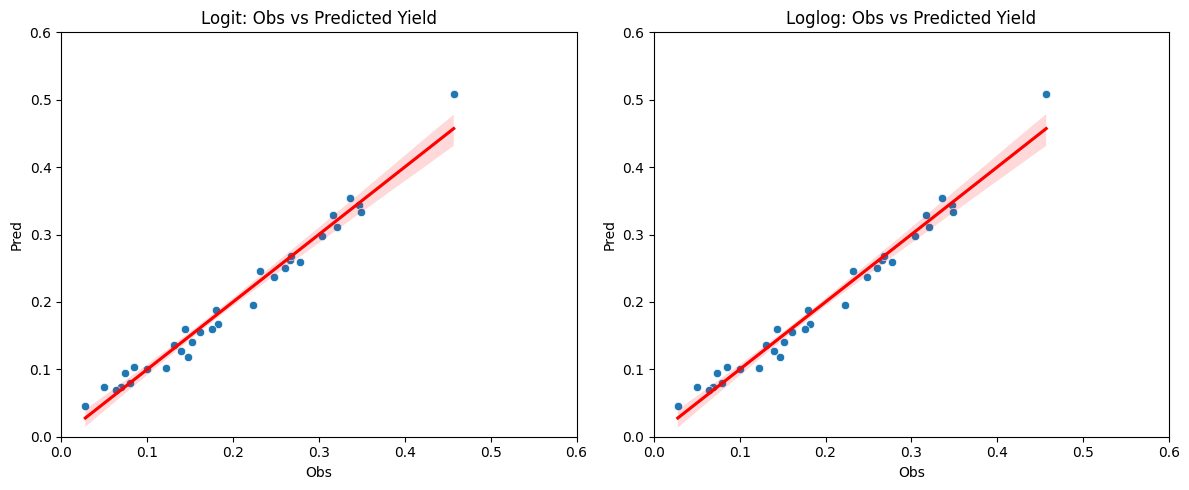

In [41]:
# Predicted vs Observed
logit_df = pd.DataFrame({'Obs': GasolineYield['yield'], 'Pred': fit_beta_01.fittedvalues})
loglog_df = pd.DataFrame({'Obs': GasolineYield['yield'], 'Pred': fit_beta_03.fittedvalues})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(data=logit_df, x='Obs', y='Pred', ax=ax1)
sns.regplot(data=logit_df, x='Obs', y='Pred', ax=ax1, scatter=False, color='red')
ax1.set_title('Logit: Obs vs Predicted Yield')
ax1.set_xlim(0, 0.6)
ax1.set_ylim(0, 0.6)

sns.scatterplot(data=loglog_df, x='Obs', y='Pred', ax=ax2)
sns.regplot(data=loglog_df, x='Obs', y='Pred', ax=ax2, scatter=False, color='red')
ax2.set_title('Loglog: Obs vs Predicted Yield')
ax2.set_xlim(0, 0.6)
ax2.set_ylim(0, 0.6)

plt.tight_layout()
plt.show()

## Summary and Conclusion

Beta regression is a powerful tool for modeling bounded continuous data, especially when the dependent variable takes values between 0 and 1, such as proportions or rates. By using the beta distribution, beta regression handles the constraints of bounded data while also providing flexibility in modeling both the mean and the dispersion of the response variable.

In this tutorial, we demonstrated how to implement beta regression from scratch in Python using maximum likelihood estimation to estimate the model parameters. Although this approach does not use specialized beta regression packages beyond core libraries, it highlights the underlying statistical principles of beta regression, including the formulation of the log-likelihood function and optimization techniques.

By understanding the mechanics of beta regression, users can effectively apply this technique to their datasets with bounded response variables, providing more accurate and meaningful predictions compared to traditional linear regression.

## References

1. [Beta Regression for Percent and Proportion Data](https://rcompanion.org/handbook/J_02.html)

2. [Beta Regression in R](https://www.zeileis.org/papers/ERCIM-2010.pdf)

3. [statsmodels BetaModel Documentation](https://www.statsmodels.org/dev/generated/statsmodels.othermod.betareg.BetaModel.html)